In [1]:
import pandas as pd
import numpy as np


train = pd.read_csv("Data/train_2016_v2.csv")    # load dataset
properties = pd.read_csv("Data/properties_2016.csv")

C:\software_program\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
train_df = train.merge(properties, how = 'left', on = 'parcelid') # get a complete dataframe

In [29]:
train_df.shape

(88465, 60)

In [4]:
# get outlier of logerror
ulimit = np.percentile(train_df.logerror.values, 99)  
print(ulimit)
llimit = np.percentile(train_df.logerror.values, 1)
print(llimit)

0.4638819999999963
-0.3425


In [5]:
# get train data without outlier

train_df = train_df[train_df.logerror > -0.3425]
train_df = train_df[train_df.logerror < 0.4639]
X_train = train_df.drop(['parcelid', 'logerror', 'transactiondate'] ,axis = 1)
y_train = train_df.logerror



In [33]:
print(y_train.shape)
label_X_train.shape

(70772,)


(70772, 57)

In [6]:
from sklearn.model_selection import train_test_split

# get training data and testing data

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size =0.8, test_size = 0.2, random_state = 0)


In [7]:
# get the data index which is categorical 

s = (X_train.dtypes =='object')
object_cols = list(s[s].index)
print(object_cols)

['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']


In [8]:
from sklearn.preprocessing import LabelEncoder


# use labelencoder to encoder X_train
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()
for col in label_X_train.columns:
    label_X_train[col] = label_X_train[col].fillna(-1)
    if label_X_train[col].dtype =='object':
        lbl = LabelEncoder()
        lbl.fit(list(label_X_train[col].values))
        label_X_train[col] = lbl.transform(list(label_X_train[col].values))

#use labelencoder to encoder X_vaid
for col in label_X_valid.columns:
    label_X_valid[col] = label_X_valid[col].fillna(-1)
    if label_X_valid[col].dtype =='object':
        lbl = LabelEncoder()
        lbl.fit(list(label_X_valid[col].values))
        label_X_valid[col] = lbl.transform(list(label_X_valid[col].values))



In [35]:
print(label_X_train.shape)
y_train.shape

(70772, 57)


(70772,)

In [9]:
# XGBoost model 1

from xgboost import XGBRegressor

XGB_model_1 = XGBRegressor(n_estimators = 500, early_stopping_rounds = 5, learning_rate = 0.05, max_depth = 7, objective='reg:linear')
XGB_model_1.fit(label_X_train, y_train)

C:\software_program\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:26:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
             gamma=0, importance_type='gain', learning_rate=0.05,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [10]:
from sklearn.metrics import mean_absolute_error

XGB_predictions_1 = XGB_model_1.predict(label_X_valid)


In [12]:
XGB_predictions_1.shape

(17693,)

In [14]:
pd.DataFrame(XGB_predictions_1).head()

,0
0,-0.000590
1,-0.002416
2,0.014133
3,0.024059
4,0.019403


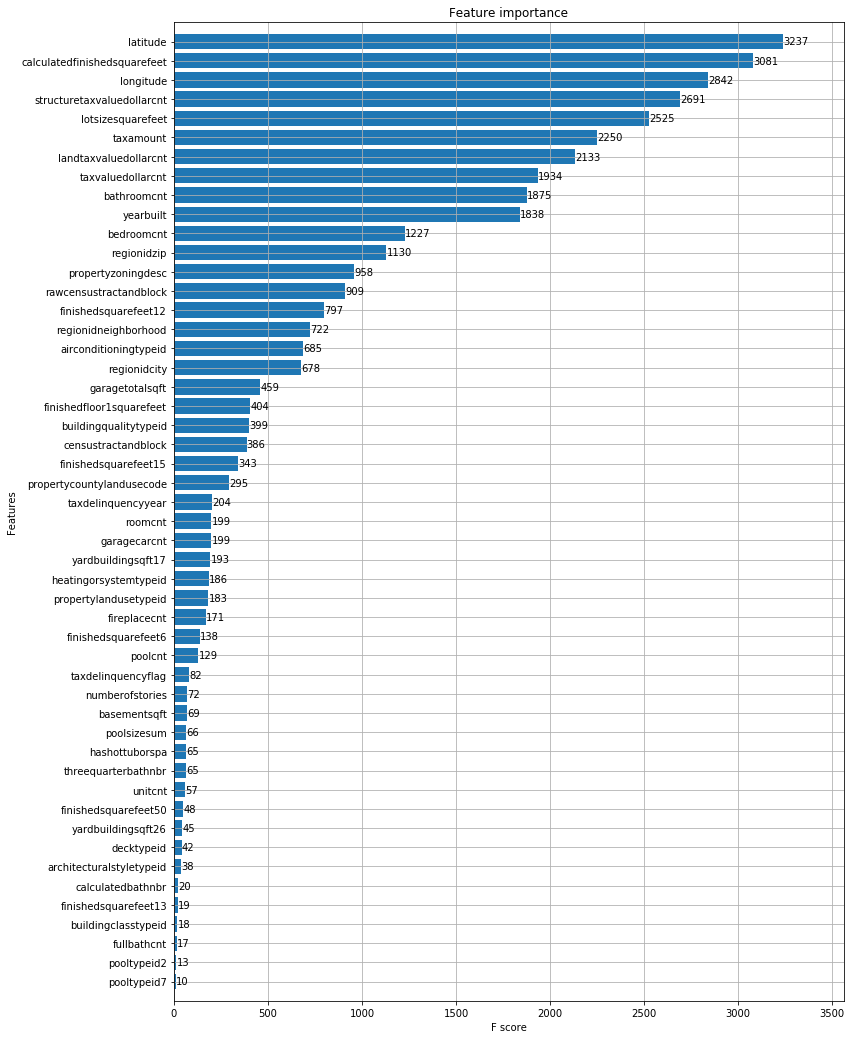

In [16]:
import matplotlib.pyplot as plt
import xgboost

fig, ax = plt.subplots(figsize=(12,18))
xgboost.plot_importance(XGB_model_1, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [25]:
mae_XGB_1 = mean_absolute_error(y_valid, XGB_predictions_1)
print(mae_XGB_1)

0.05271126046732674


In [19]:
# get feature which importance score is higher than 600 from the picture
selected_features = ['taxamount', 'calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 'longitude',
                                     'finishedsquarefeet12', 'latitude','regionidzip','taxvaluedollarcnt','lotsizesquarefeet',
                                    'landtaxvaluedollarcnt','rawcensustractandblock','yearbuilt','propertyzoningdesc'
                                    ,'taxdelinquencyyear','bathroomcnt','bedroomcnt','regionidneighborhood' ]

In [20]:
select_X_train = label_X_train[selected_features]
select_X_valid = label_X_valid[selected_features]



In [21]:
XGB_model_2 =  XGBRegressor(n_estimators = 500, early_stopping_rounds = 5, learning_rate = 0.05, max_depth = 7, objective='reg:linear')
XGB_model_2.fit(select_X_train, y_train)

C:\software_program\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:37:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
             gamma=0, importance_type='gain', learning_rate=0.05,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [27]:
XGB_predictions_2 = XGB_model_2.predict(select_X_valid)

In [28]:
from sklearn.metrics import mean_absolute_error

mae_XGB_2 = mean_absolute_error(y_valid, XGB_predictions_2)
print(mae_XGB_2)

0.052793988536878805
